<h1>CIFAR-10 convnet demo</h1>
More or less analogous to the MNIST notebook. This time we're fitting a subset of CIFAR-10.

In [1]:
import ntb
from ntb.datasets import cifar10
import matplotlib.pyplot as pp
import numpy as np

%matplotlib inline

In [2]:
data,vis = cifar10.load(num_train=20000,num_val=2000)

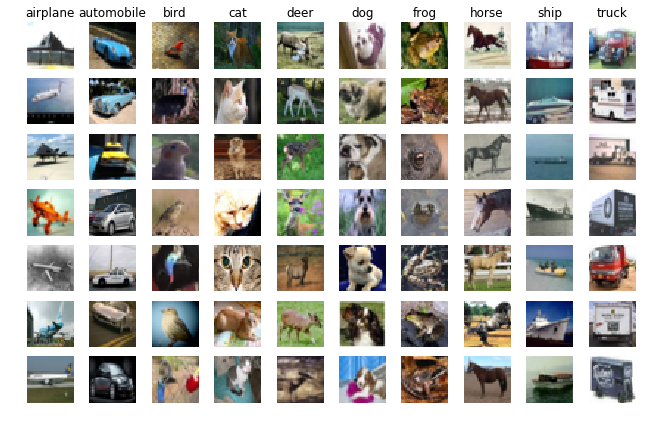

In [3]:
vis()

In [4]:
#we construct a computational graph for a convnet similar to the one from the mnist example
graph = ntb.ComputationGraph()

with ntb.default_graph(graph):
    x = ntb.Placeholder(shape=[-1,3,32,32])
    y = ntb.Placeholder(shape=[-1])
    p = ntb.Placeholder()
    lr = ntb.Placeholder()
    train = ntb.Placeholder()

    h1,w1,_ = ntb.conv_layer(x,20,5,5,stride=2,padding='same')
    s1 = ntb.max_pool_layer(h1,2,2)
    b1,_,_ = ntb.spatial_batchnorm_layer(s1,train)
    r1 = ntb.Relu(b1)

    h2,w2,_ = ntb.conv_layer(r1,14,5,5,stride=1,padding='minimal')
    b2,_,_ = ntb.spatial_batchnorm_layer(h2,train)
    r2 = ntb.Relu(b2)
    do2 = ntb.Dropout(r2,p)
    
    a3,_,_ = ntb.affine_layer(do2,34)
    b3,_,_ = ntb.batchnorm_layer(a3,train)
    r3 = ntb.Relu(b3)
    do3 = ntb.Dropout(r3,p)
    
    a4,_,_ = ntb.affine_layer(do3,16)
    b4,_,_ = ntb.batchnorm_layer(a4,train)
    r4 = ntb.Relu(b4)
    
    scores,_,_ = ntb.affine_layer(r4,10)
    pred = ntb.Argmax(scores,axis=1)
    acc = ntb.ClassAccuracy(pred,y)
    loss = ntb.CrossEntropyLogits(scores,y)

    optim = ntb.Optim(loss,lr=lr,update_rule='adam')

In [5]:
def train_step(X_tr,y_tr,learning_rate,keep_prob,train_batchnorm=True):
    loss_tr,_=graph.run([loss,optim],{x:X_tr,y:y_tr,
                                      p:keep_prob,
                                      train:train_batchnorm,
                                      lr:learning_rate})
    return ('batch loss',loss_tr),

def epoch_step(X_tr,y_tr,X_val,y_val):
    loss_tr,acc_tr=graph.run([loss,acc],{x:X_tr,y:y_tr,
                                         p:1.,train:False})
    loss_val,acc_val=graph.run([loss,acc],{x:X_val,y:y_val,
                                           p:1.,train:False})
    return ('train loss',loss_tr),('train acc',acc_tr),('val loss',loss_val),('val acc',acc_val)

def predict(X):
    return graph.run([pred],{x:X,p:1.,train:False})[0]

model = ntb.Model(train_step,epoch_step,predict,graph.reset,graph.save,graph.load)

solver = ntb.Solver(data=data,model=model,batch_size=500,metric='val acc')

In [7]:
#train for 10 epochs
#the best-performing model (evaluated epoch-wise) is saved
#and restored at the end of training

solver.train(num_epochs=10,learning_rate=3e-2,keep_prob=.9)

(Iteration 0/400) batch loss:2.5871
(New best) val acc: 0.1285
(Epoch 0/10) train loss:34.4363, train acc:0.133, val loss:35.7208, val acc:0.1285
(Iteration 10/400) batch loss:1.9089
(Iteration 20/400) batch loss:1.719
(Iteration 30/400) batch loss:1.6119
(Iteration 40/400) batch loss:1.5751
(New best) val acc: 0.395
(Epoch 1/10) train loss:1.7188, train acc:0.377, val loss:1.6628, val acc:0.395
(Iteration 50/400) batch loss:1.4595
(Iteration 60/400) batch loss:1.5091
(Iteration 70/400) batch loss:1.4186
(Iteration 80/400) batch loss:1.4412
(Epoch 2/10) train loss:2.0511, train acc:0.345, val loss:2.0898, val acc:0.347
(Iteration 90/400) batch loss:1.3712
(Iteration 100/400) batch loss:1.3326
(Iteration 110/400) batch loss:1.4057
(Iteration 120/400) batch loss:1.4332
(New best) val acc: 0.4595
(Epoch 3/10) train loss:1.5841, train acc:0.453, val loss:1.5725, val acc:0.4595
(Iteration 130/400) batch loss:1.3093
(Iteration 140/400) batch loss:1.3357
(Iteration 150/400) batch loss:1.3075


In [8]:
solver.train(num_epochs=10,learning_rate=1e-3,keep_prob=.9)

(Iteration 0/400) batch loss:1.1483
(New best) val acc: 0.563
(Epoch 0/10) train loss:1.1445, train acc:0.584, val loss:1.2197, val acc:0.563
(Iteration 10/400) batch loss:1.056
(Iteration 20/400) batch loss:1.0475
(Iteration 30/400) batch loss:1.0458
(Iteration 40/400) batch loss:1.0586
(New best) val acc: 0.588
(Epoch 1/10) train loss:1.0538, train acc:0.624, val loss:1.1225, val acc:0.588
(Iteration 50/400) batch loss:1.1097
(Iteration 60/400) batch loss:1.0708
(Iteration 70/400) batch loss:1.0336
(Iteration 80/400) batch loss:1.0563
(New best) val acc: 0.6025
(Epoch 2/10) train loss:0.9747, train acc:0.674, val loss:1.1079, val acc:0.6025
(Iteration 90/400) batch loss:1.026
(Iteration 100/400) batch loss:1.0884
(Iteration 110/400) batch loss:1.0566
(Iteration 120/400) batch loss:1.1077
(New best) val acc: 0.603
(Epoch 3/10) train loss:0.9276, train acc:0.664, val loss:1.1029, val acc:0.603
(Iteration 130/400) batch loss:1.1185
(Iteration 140/400) batch loss:1.059
(Iteration 150/400

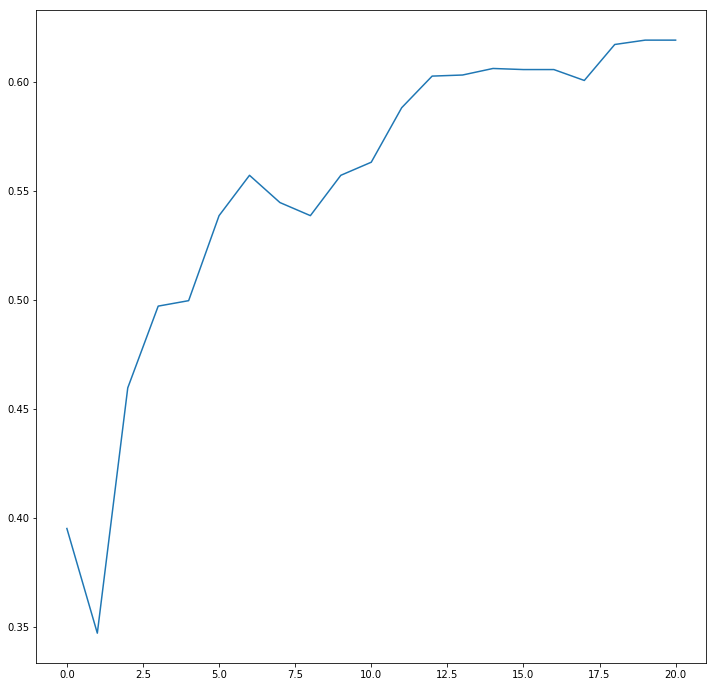

In [18]:
pp.plot(solver.history['val acc'][1:])

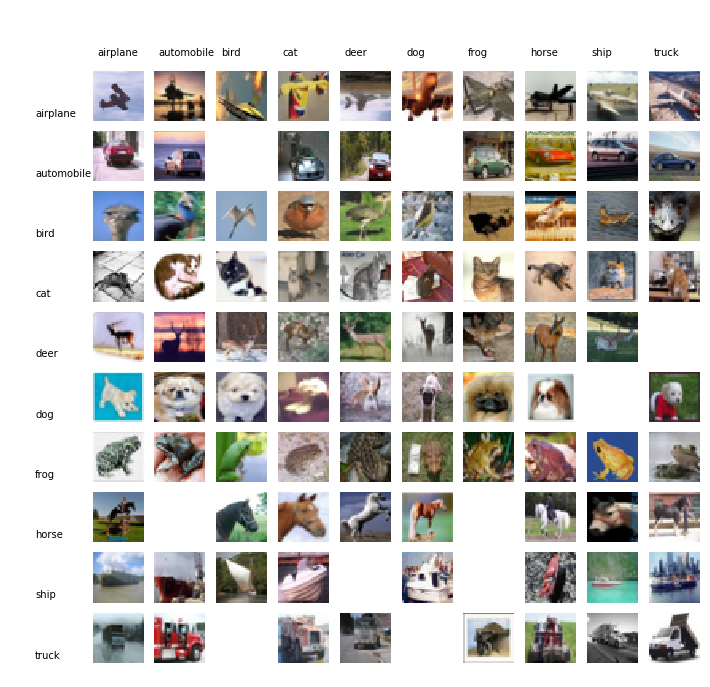

In [15]:
ntb.datasets.vis.render_confusion_sample(data=data,model=model,figsize=(12.0,12.0))

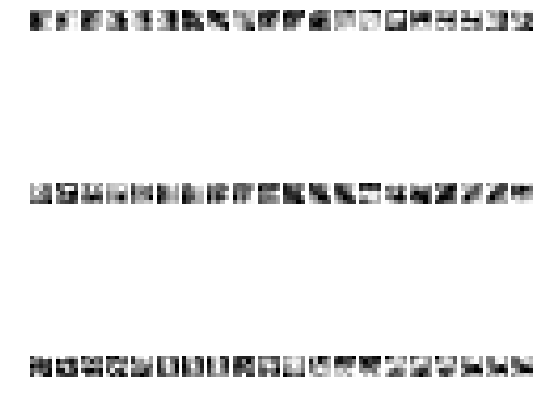

In [13]:
ntb.vis.render_cnn_filters(w1.value)

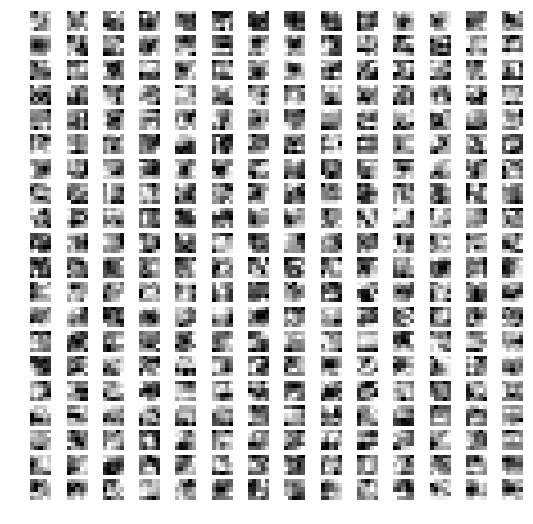

In [14]:
ntb.vis.render_cnn_filters(w2.value)